In [138]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [139]:
# read in all the words
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [140]:
len(words)

32033

In [141]:
# build the vocabulary
chars = sorted(list(set(''.join(words))))
char_to_int = {c: i+1 for i, c in enumerate(chars)}
char_to_int['.'] = 0
int_to_char = {i: c for c, i  in char_to_int.items()}

vocab_size = len(int_to_char)
print(int_to_char)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [142]:
# build the dataset
block_size = 3

def build_dataset(words, block_size):
    X, Y = [], []

    for word in words:
        context = [0] * block_size

        for char in word + '.':
            index = char_to_int[char]
            X.append(context)
            Y.append(index)
            context = context[1:] + [index]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# train, validation, test split
import random
random.seed(42)
random.shuffle(words)

split_index_1 = int(len(words) * 0.8)
split_index_2 = int(len(words) * 0.9)

X_train, Y_train = build_dataset(words[:split_index_1], block_size) # 80% of the data
X_valid, Y_valid = build_dataset(words[split_index_1:split_index_2], block_size) # 10% of the data
X_test, Y_test = build_dataset(words[split_index_2:], block_size) # 10% of the data



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [143]:
# Initialize MLP model
num_embeddings = 10 # the dimensionality of the character embedding space
num_hidden = 200 # the number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, num_embeddings, generator=g)
W1 = torch.randn(num_embeddings * block_size, num_hidden, generator=g) * ((5/3)/(num_embeddings * block_size**0.5)) # scale down the weights; kaiming initialization
# b1 = torch.randn(num_hidden, generator=g) * 0.01 # scale down the bias
W2 = torch.randn(num_hidden, vocab_size, generator=g) * 0.01 # scale down the weights
b2 = torch.randn(vocab_size, generator=g) * 0 # no bias in the output layer

batch_norm_gain = torch.ones((1, num_hidden))
batch_norm_bias = torch.zeros((1, num_hidden))

batch_mean_running = torch.zeros((1, num_hidden))
batch_std_running = torch.ones((1, num_hidden))

parameters = [C, W1, W2, b2, batch_norm_gain, batch_norm_bias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


step 0 / 200000: loss 3.324
step 10000 / 200000: loss 2.103
step 20000 / 200000: loss 2.586
step 30000 / 200000: loss 1.966
step 40000 / 200000: loss 2.272
step 50000 / 200000: loss 1.795
step 60000 / 200000: loss 2.121
step 70000 / 200000: loss 2.377
step 80000 / 200000: loss 2.420
step 90000 / 200000: loss 2.083
step 100000 / 200000: loss 2.349
step 110000 / 200000: loss 2.351
step 120000 / 200000: loss 1.686
step 130000 / 200000: loss 1.995
step 140000 / 200000: loss 2.243
step 150000 / 200000: loss 2.004
step 160000 / 200000: loss 2.096
step 170000 / 200000: loss 2.403
step 180000 / 200000: loss 2.061
step 190000 / 200000: loss 2.071


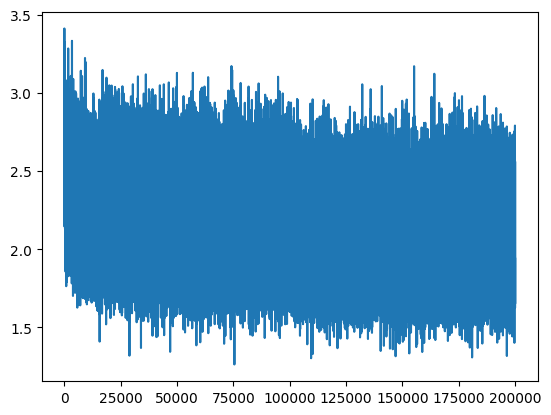

In [144]:
# optimization
max_steps = 200000
batch_size = 32
losses = []

for step in range(max_steps):
    # mini-batch sampling
    indices = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch = X_train[indices]
    Y_batch = Y_train[indices]

    # forward pass
    embedding = C[X_batch] # embed the characters into vectors
    embedding_cat = embedding.view(embedding.shape[0], -1) # concatenate the vectors
    hidden = embedding_cat @ W1 # compute the hidden layer, pre-activation
    
    # batch normalization layer
    batch_mean = hidden.mean(0, keepdim=True) # compute the batch mean
    batch_std = hidden.std(0, keepdim=True) # compute the batch standard deviation
    hidden_norm = batch_norm_gain * (hidden - batch_mean) / batch_std + batch_norm_bias # apply batch normalization
    
    with torch.no_grad():    
        batch_mean_running = 0.999 * batch_mean_running + 0.001 * batch_mean # update the running mean
        batch_std_running = 0.999 * batch_std_running + 0.001 * batch_std # update the running standard deviation

    # activation layer  
    hidden_act = torch.tanh(hidden_norm) # apply the activation function
    logits = hidden_act @ W2 + b2 # compute the logits
    loss = F.cross_entropy(logits, Y_batch) # compute the loss

    # backward pass
    for p in parameters:
        p.grad = None # zero out the gradients
    
    loss.backward() # compute the gradients

    # gradient descent
    learning_rate = 0.1 if step < 100000 else 0.01

    for p in parameters:
        p.data -= p.grad * learning_rate

    # track stats
    if step % 10000 == 0:
        print(f'step {step} / {max_steps}: loss {loss.item():.3f}')
    
    losses.append(loss.item())

# plot the loss
plt.plot(losses)
plt.show()


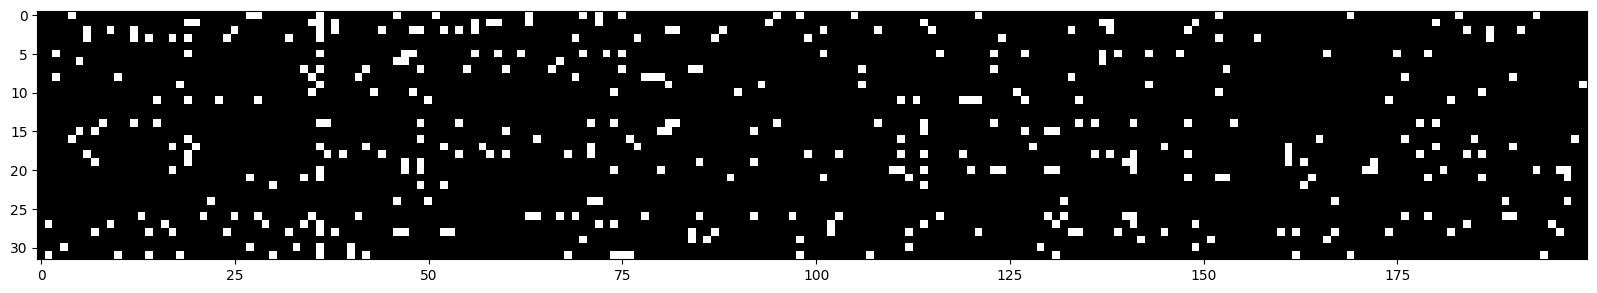

In [145]:
plt.figure(figsize=(20, 10))
plt.imshow(hidden_act.abs() > 0.99, cmap='gray', interpolation='nearest');

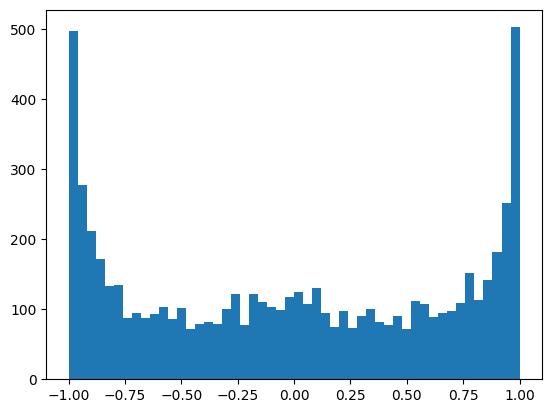

In [146]:
plt.hist(hidden_act.view(-1).tolist(), 50);

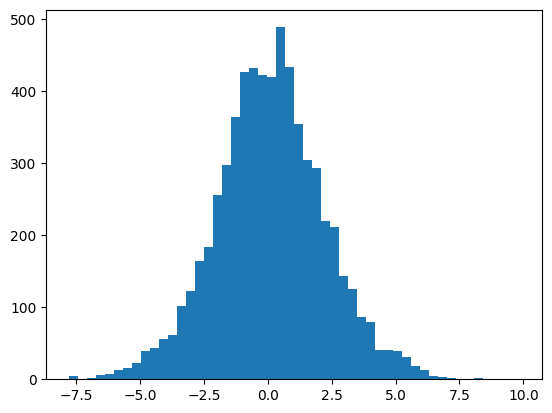

In [147]:
plt.hist(hidden.view(-1).tolist(), 50);

In [148]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'valid': (X_valid, Y_valid),
        'test': (X_test, Y_test),
    }[split]

    embedding = C[x] # (N, block_size, num_embeddings)
    embedding_cat = embedding.view(embedding.shape[0], -1) # (N, block_size * num_embeddings)
    hidden = embedding_cat @ W1 # (N, num_hidden)
    # batch normalization
    hidden_norm = batch_norm_gain * (hidden - batch_mean_running) / batch_std_running + batch_norm_bias # apply batch normalization
    #-----
    hidden_act = torch.tanh(hidden_norm) # (N, num_hidden)
    logits = hidden_act @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) # (1)
    print(split, loss.item())

split_loss('train')
split_loss('valid')

train 2.0596511363983154
valid 2.1066300868988037


In [149]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    output = []
    context = [0] * block_size # initialize the context with '...'

    while True:
        # forward pass
        embedding = C[torch.tensor([context])] # (block_size, num_embeddings)
        hidden = embedding.view(1, -1) @ W1
        hidden_norm = batch_norm_gain * (hidden - batch_mean_running) / batch_std_running + batch_norm_bias # apply batch normalization
        hidden_act = torch.tanh(hidden_norm) # (1, num_hidden)
        logits = hidden_act @ W2 + b2 # (1, vocab_size)
        probs = F.softmax(logits, dim=1) # (1, vocab_size)
        
        # sample a character
        index = torch.multinomial(probs, num_samples=1, generator=g).item() # (1)

        # update the context
        context = context[1:] + [index]

        # add the character index to the output
        output.append(index)

        # stop if we hit a period (index 0)
        if index == 0:
            break

    print(''.join(int_to_char[i] for i in output))




carlah.
amelle.
khi.
milia.
aty.
sacassie.
mahnee.
delynn.
jareei.
ner.
kiah.
maiir.
kaleigh.
ham.
join.
quinthorlin.
alianni.
watell.
dearyxia.
kael.
